# 8. Join Retail Data with Street Network Data

**At this point we have:**
1. Conducted a simple percolation to identify 1483 urban systems within the UK. The exact parameters were defined using research from *Arcaute et al. (2016)*
2. We then idenitfied the most relevant clusters for our analysis
3. After identiyfing the most useful clusters for our analysis we calculated the betweeness centrality of our edges and nodes

We are now interested in joining our clustered data with our retail data. The reason for this is that we are looking to assess the relationship between the spatial hierarchy and the types of businesses that correlate to different values of betweeness centrality in the UK.

To draw this relationship we conduct a spatial join between our *POI* data and our *Street Network* Data.

This notebook is dedicated to this join.

In [1]:
# load relevant packages for analysis
import cityseer as cs
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import igraph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
from rtree import index
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
from shapely.ops import nearest_points
import shapely.wkt
from shapely import wkt
import statsmodels.api as sm
import sys
from xml import etree

# A. Read and Process Retail and Street Data

### 1. First we read in both datasets

In [2]:
# read retail data
retail = gpd.read_file('Data/OS_POIs/poi_uk.gpkg')
# read in street network data
G_betw = nx.read_graphml('Data/G_betw2.graphml')

In [19]:
retail.head()

,ref_no,name,pointx_class,groupname,categoryname,classname,feature_easting,feature_northing,pos_accuracy,uprn,...,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,geometry
0,18191779,Field System,03170240,Attractions,Historical and Cultural,Archaeological Sites,422635.0,176212.0,2,NaN,...,SN8,Wiltshire,None,None,None,None,None,Ordnance Survey,2024-06-01,POINT (422635.000 176212.000)
1,17967878,Fountain,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,523926.0,165927.0,2,NaN,...,SM3,Sutton London Boro,None,None,None,None,None,Ordnance Survey,2024-06-01,POINT (523926.000 165927.000)
2,18191780,Earthwork,03170240,Attractions,Historical and Cultural,Archaeological Sites,426521.0,172243.0,2,NaN,...,SN8,Wiltshire,None,None,None,None,None,Ordnance Survey,2024-06-01,POINT (426521.000 172243.000)
3,18191781,Field System,03170240,Attractions,Historical and Cultural,Archaeological Sites,420303.0,175924.0,2,NaN,...,SN8,Wiltshire,None,None,None,None,None,Ordnance Survey,2024-06-01,POINT (420303.000 175924.000)
4,18213857,Waterfall,03190257,Attractions,Landscape Features,Designated Scenic Features,239894.0,664536.0,2,NaN,...,PA11,Renfrewshire,None,None,None,None,None,Ordnance Survey,2024-06-01,POINT (239894.000 664536.000)


### 2. Next we ensure the datasets are in the same CRS
The Ordnance Survey Confirms that the [OpenRoads data is stored in EPSG: 27700](https://www.ordnancesurvey.co.uk/documents/product-support/user-guide/os-open-roads-overview.pdf). Therefore, we need only to confirm the CRS of the Retail Data.

In [4]:
graph_crs = 'EPSG:27700'

In [5]:
# check CRS of both datasets
retail_crs = retail.crs
print(f'Retail locations CRS: {retail_crs}')

Retail locations CRS: EPSG:27700


### 3. Create GDF for Graph Nodes & Edges

In [6]:
# get node data & create gdf
nodes_data = []
for node, data in G_betw.nodes(data=True):
    geom = data.get('geometry')
    if geom:
        x, y = map(float, geom.replace('POINT (', '').replace(')', '').split())
        nodes_data.append((node, x, y, geom, data.get('betweenness', 0)))

nodes_df = pd.DataFrame(nodes_data, columns=['node', 'x', 'y', 'geometry', 'betweenness'])
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['x'], nodes_df['y']), crs=graph_crs)

In [7]:
nodes_gdf.head()

,node,x,y,geometry,betweenness
0,494F06C3-9539-4F7C-A4B9-4BBA6D37BA41,148230.00,844043.00,POINT (148230.000 844043.000),0.012543
1,B4C0E062-CC19-4321-9B2B-0AD92E4BFA11,446265.16,1140717.23,POINT (446265.160 1140717.230),0.094412
2,44F5B1DD-6A05-463B-B62F-65071BC033EC,446086.48,1140705.03,POINT (446086.480 1140705.030),0.011544
3,A13C67D7-94B8-42FA-9287-B6848995F85F,446276.70,1140656.70,POINT (446276.700 1140656.700),0.141811
4,85E30CD0-3AB2-40C0-B3B4-C99096C82A7A,446268.79,1140751.99,POINT (446268.790 1140751.990),0.072732


In [8]:
nodes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1405754 entries, 0 to 1405753
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   node         1405754 non-null  object  
 1   x            1405754 non-null  float64 
 2   y            1405754 non-null  float64 
 3   geometry     1405754 non-null  geometry
 4   betweenness  1405754 non-null  float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 53.6+ MB


In [9]:
# get edge data & create gdf
edges_data = []
for u, v, data in G_betw.edges(data=True):
    if 'geometry' in data:
        line = LineString([(float(coord.split()[0]), float(coord.split()[1])) for coord in data['geometry'].replace('LINESTRING (', '').replace(')', '').split(', ')])
        edges_data.append((u, v, line, data.get('betweenness', 0)))

edges_df = pd.DataFrame(edges_data, columns=['u', 'v', 'geometry', 'betweenness'])
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry', crs=graph_crs)

In [10]:
edges_gdf.head()

,u,v,geometry,betweenness
0,494F06C3-9539-4F7C-A4B9-4BBA6D37BA41,CAF8EC0B-4D68-4258-802F-5C03F74579C4,"LINESTRING (148262.000 844045.000, 148246.000 ...",0.012354
1,494F06C3-9539-4F7C-A4B9-4BBA6D37BA41,04095C39-43DA-4761-94EF-143BD0152036,"LINESTRING (148230.000 844043.000, 148215.500 ...",0.012534
2,B4C0E062-CC19-4321-9B2B-0AD92E4BFA11,44F5B1DD-6A05-463B-B62F-65071BC033EC,"LINESTRING (446265.160 1140717.230, 446175.820...",0.017191
3,B4C0E062-CC19-4321-9B2B-0AD92E4BFA11,A13C67D7-94B8-42FA-9287-B6848995F85F,"LINESTRING (446265.160 1140717.230, 446270.930...",0.098649
4,B4C0E062-CC19-4321-9B2B-0AD92E4BFA11,85E30CD0-3AB2-40C0-B3B4-C99096C82A7A,"LINESTRING (446268.790 1140751.990, 446266.970...",0.077660


In [11]:
edges_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1722640 entries, 0 to 1722639
Data columns (total 4 columns):
 #   Column       Dtype   
---  ------       -----   
 0   u            object  
 1   v            object  
 2   geometry     geometry
 3   betweenness  float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 52.6+ MB


# B. Conduct Spatial Join
The two datasets have been correctly read into this .ipynb. A key part of our analysis going forward is ensuring the retail data is correctly mapped to the correct street.

The provided code for Step 3 performs a series of operations to match retail points to the nearest road segments and enrich the retail data with road attributes. It starts by loading necessary libraries (geopandas, networkx, shapely.geometry, and scipy.spatial.cKDTree) and the two datasets: OS Open Roads and retail points, ensuring both are in the same CRS (EPSG:27700). A spatial index for the road segments is created using the centroids of the road geometries to facilitate efficient nearest neighbour searches. The code defines a function to find the nearest road segment for a given retail point by querying this spatial index and applies this function to all retail points. It then creates a DataFrame linking each retail point to its nearest road segment. Finally, the retail points are enriched with road attributes, specifically betweenness centrality values, by merging the data from the road segments. The enriched data is then saved for further analysis.

In [12]:
# ensure CRS match
retail = retail.to_crs('EPSG:27700')

## 1. Create a spatial index for the street network edges

In [13]:
# Extract edges from the graph and create a GeoDataFrame
edges = []
for u, v, data in G_betw.edges(data=True):
    if isinstance(data['geometry'], str):
        geom = wkt.loads(data['geometry'])
    else:
        geom = data['geometry']
    line = LineString(geom)
    edges.append({
        'u': u,
        'v': v,
        'geometry': line,
        'betweenness': data.get('betweenness', 0)
    })

edges_gdf = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:27700')

# Create a spatial index for the edges
idx = index.Index()
for edge_id, geom in enumerate(edges_gdf.geometry):
    idx.insert(edge_id, geom.bounds)

In [ ]:
def find_nearest_edge(point, edges_gdf, idx):
    point_geom = point.geometry
    nearest_edge_id = list(idx.nearest((point_geom.x, point_geom.y, point_geom.x, point_geom.y), 1))[0]
    nearest_edge = edges_gdf.iloc[nearest_edge_id]
    return nearest_edge_id, nearest_edge['geometry'], nearest_edge['betweenness']

# Apply the function to each retail point
retail['nearest_edge'], retail['nearest_geometry'], retail['betweenness'] = zip(*retail.apply(find_nearest_edge, edges_gdf=edges_gdf, idx=idx, axis=1))

In [28]:
# verify
retail.head()

,Unnamed: 0,ref_no,name,pointx_class,groupname,categoryname,classname,feature_easting,feature_northing,pos_accuracy,...,url,brand,qualifier_type,qualifier_data,provenance,supply_date,geometry,nearest_edge,nearest_geometry,betweenness
0,0,18191779,Field System,3170240,Attractions,Historical and Cultural,Archaeological Sites,422635.0,176212.0,2,...,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (422635 176212),171859,"LINESTRING (419012.5 181177.64, 419009.12 1811...",0.001047
1,1,17967878,Fountain,3170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,523926.0,165927.0,2,...,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (523926 165927),747295,"LINESTRING (523917 165796, 523888.38 165815.94...",0.000982
2,2,18191780,Earthwork,3170240,Attractions,Historical and Cultural,Archaeological Sites,426521.0,172243.0,2,...,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (426521 172243),871207,"LINESTRING (420328.09 169107.43, 420311.13 169...",0.011080
3,3,18191781,Field System,3170240,Attractions,Historical and Cultural,Archaeological Sites,420303.0,175924.0,2,...,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (420303 175924),1575560,"LINESTRING (418842.11 181140.63, 418794.23 181...",0.000262
4,4,18213857,Waterfall,3190257,Attractions,Landscape Features,Designated Scenic Features,239894.0,664536.0,2,...,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (239894 664536),1179855,"LINESTRING (239986 664832, 239960.31 664824.58...",0.017936


In [29]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663899 entries, 0 to 3663898
Data columns (total 33 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   ref_no             int64  
 2   name               object 
 3   pointx_class       int64  
 4   groupname          object 
 5   categoryname       object 
 6   classname          object 
 7   feature_easting    float64
 8   feature_northing   float64
 9   pos_accuracy       int64  
 10  uprn               float64
 11  topo_toid          object 
 12  topo_toid_version  int64  
 13  usrn               int64  
 14  usrn_mi            int64  
 15  distance           float64
 16  address_detail     object 
 17  street_name        object 
 18  locality           object 
 19  geographic_county  object 
 20  postcode           object 
 21  admin_boundary     object 
 22  telephone_number   float64
 23  url                object 
 24  brand              object 
 25  qualifier_type    

In [ ]:
retail.to_csv('Data/retailw_betweeness.csv')

# C. Correlation Analysis: Betweeness and POI Data

### C1. Data Preparation

In [4]:
# columns
columns_to_keep = [
    'groupname', 'categoryname', 'classname', 'street_name',
    'locality', 'geographic_county', 'postcode', 'geometry', 'betweenness'
]

# Define the data types for each column to avoid mixed types
dtype_dict = {
    'groupname': 'str',
    'categoryname': 'str',
    'classname': 'str',
    'street_name': 'str',
    'locality': 'str',
    'geographic_county': 'str',
    'postcode': 'str',
    'geometry': 'str',  # Keep as string to convert later
    'betweenness': 'float64'
}

# Read the CSV file into a DataFrame
df = pd.read_csv('Data/retailw_betweeness.csv', usecols=columns_to_keep, dtype=dtype_dict, low_memory=False)

# Convert the 'geometry' column from WKT to Shapely geometries
df['geometry'] = df['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame, specifying the geometry column
retail_gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [5]:
retail_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3663899 entries, 0 to 3663898
Data columns (total 9 columns):
 #   Column             Dtype   
---  ------             -----   
 0   groupname          object  
 1   categoryname       object  
 2   classname          object  
 3   street_name        object  
 4   locality           object  
 5   geographic_county  object  
 6   postcode           object  
 7   geometry           geometry
 8   betweenness        float64 
dtypes: float64(1), geometry(1), object(7)
memory usage: 251.6+ MB


In [6]:
retail_gdf.head()

,groupname,categoryname,classname,street_name,locality,geographic_county,postcode,geometry,betweenness
0,Attractions,Historical and Cultural,Archaeological Sites,NaN,NaN,Wiltshire,SN8,POINT (422635.000 176212.000),0.001047
1,Attractions,Historical and Cultural,Historic and Ceremonial Structures,NaN,NaN,Greater London,SM3,POINT (523926.000 165927.000),0.000982
2,Attractions,Historical and Cultural,Archaeological Sites,NaN,NaN,Wiltshire,SN8,POINT (426521.000 172243.000),0.011080
3,Attractions,Historical and Cultural,Archaeological Sites,NaN,NaN,Wiltshire,SN8,POINT (420303.000 175924.000),0.000262
4,Attractions,Landscape Features,Designated Scenic Features,NaN,NaN,Renfrewshire,PA11,POINT (239894.000 664536.000),0.017936


In [7]:
# Filter the GeoDataFrame to keep only the desired group names
retail_filtered_gdf = retail_gdf[retail_gdf['groupname'].isin(['Retail', 'Accommodation, Eating and Drinking'])]

# Display the filtered GeoDataFrame info to confirm
retail_filtered_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 537775 entries, 158808 to 3635244
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   groupname          537775 non-null  object  
 1   categoryname       537775 non-null  object  
 2   classname          537775 non-null  object  
 3   street_name        505221 non-null  object  
 4   locality           529628 non-null  object  
 5   geographic_county  537775 non-null  object  
 6   postcode           537775 non-null  object  
 7   geometry           537775 non-null  geometry
 8   betweenness        537775 non-null  float64 
dtypes: float64(1), geometry(1), object(7)
memory usage: 41.0+ MB


In [8]:
retail_filtered_gdf.head()

,groupname,categoryname,classname,street_name,locality,geographic_county,postcode,geometry,betweenness
158808,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,Cliff Lane,Warrington,Cheshire,WA13 0SP,POINT (366521.400 384762.000),0.005216
158809,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,Biggar,NaN,Lanarkshire,ML12 6RG,POINT (292990.000 625056.000),0.020512
158810,"Accommodation, Eating and Drinking",Eating and Drinking,Banqueting and Function Rooms,NaN,"Englefield, Reading",Berkshire,RG7 5EN,POINT (462226.000 171939.000),0.003902
158811,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,Dunmow Road,Bishop's Stortford,Essex,CM23 5QZ,POINT (551204.000 221498.000),0.003663
158812,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,M62,"Great Sankey, Warrington",Cheshire,WA5 3AX,POINT (357697.000 391351.000),0.000818


In [9]:
unique_classnames = retail_filtered_gdf['classname'].unique()
print(unique_classnames)

['Restaurants' 'Banqueting and Function Rooms' 'Self Catering'
 'Cafes, Snack Bars and Tea Rooms' 'Hobby, Sports and Pastime Products'
 'Hotels, Motels, Country Houses and Inns' 'Pubs, Bars and Inns'
 'Bed and Breakfast and Backpacker Accommodation'
 'Camping, Caravanning, Mobile Homes, Holiday Parks and Centres'
 'Timeshare' 'Youth Accommodation' 'Fast Food and Takeaway Outlets'
 'Hostels and Refuges For The Homeless'
 'Convenience Stores and Independent Supermarkets'
 'Jewellery and Fashion Accessories' 'Travel Agencies' 'Bakeries'
 'Lingerie and Hosiery' 'Grocers, Farm Shops and Pick Your Own'
 'Gifts and Cards' 'Garden Centres and Nurseries' 'Fish and Chip Shops'
 'Diy and Home Improvement' 'Fast Food Delivery Services'
 'Camping and Caravanning' 'Art and Antiques' 'Tea and Coffee Merchants'
 'Florists' 'Butchers' 'New Vehicles' 'Secondhand Goods'
 'Secondhand Vehicles'
 'Alcoholic Drinks Including Off Licences and Wholesalers' 'Potteries'
 'Internet Cafes' 'Charity Shops' 'Delicat

In [10]:
# Group the GeoDataFrame by 'classname' and calculate the median betweenness for each group
median_betweenness = retail_filtered_gdf.groupby('classname')['betweenness'].median().reset_index()

# Rename the columns for clarity
median_betweenness.columns = ['classname', 'median_betweenness']
median_betweenness

,classname,median_betweenness
0,Adult Shops,0.003030
1,Alcoholic Drinks Including Off Licences and Wh...,0.002830
2,Art and Antiques,0.008696
3,Baby and Nursery Equipment and Children'S Clothes,0.004130
4,Bakeries,0.005141
...,...,...
79,Timeshare,0.010373
80,Travel Agencies,0.003491
81,Vehicle Auctions,0.004853
82,Vehicle Parts and Accessories,0.005162


### C4: Correlation between categoryname and betweeness

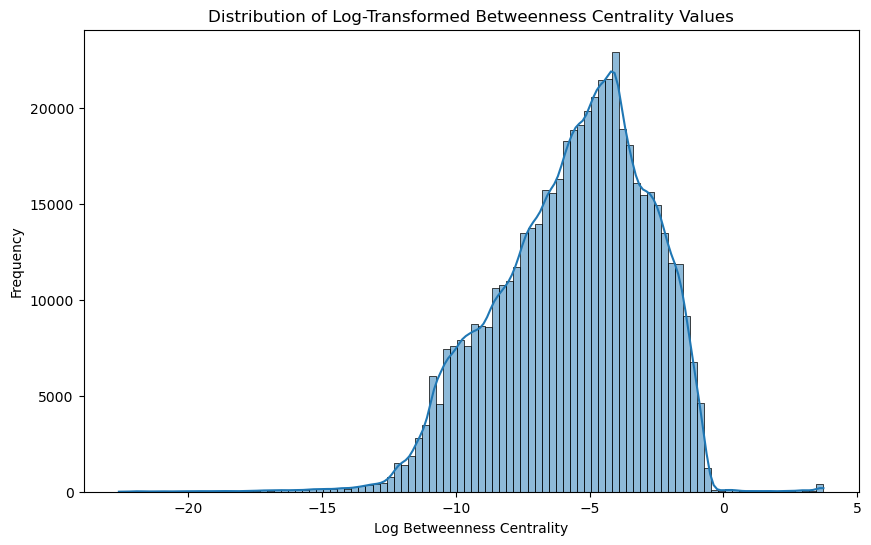

In [11]:
# plot
betweenness_values = retail_filtered_gdf['betweenness']

# log betweenness plot
log_betweenness_values = np.log(betweenness_values + 1e-10)
plt.figure(figsize=(10, 6))
sns.histplot(log_betweenness_values, bins=100, kde=True)
plt.title('Distribution of Log-Transformed Betweenness Centrality Values')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

Spearman Correlation Coefficient (Median): -0.05202380399195167
P-value (Median): 0.40533440956203903
Spearman Correlation Coefficient (Mean): -0.023791763634311822
P-value (Mean): 0.7036852500114663


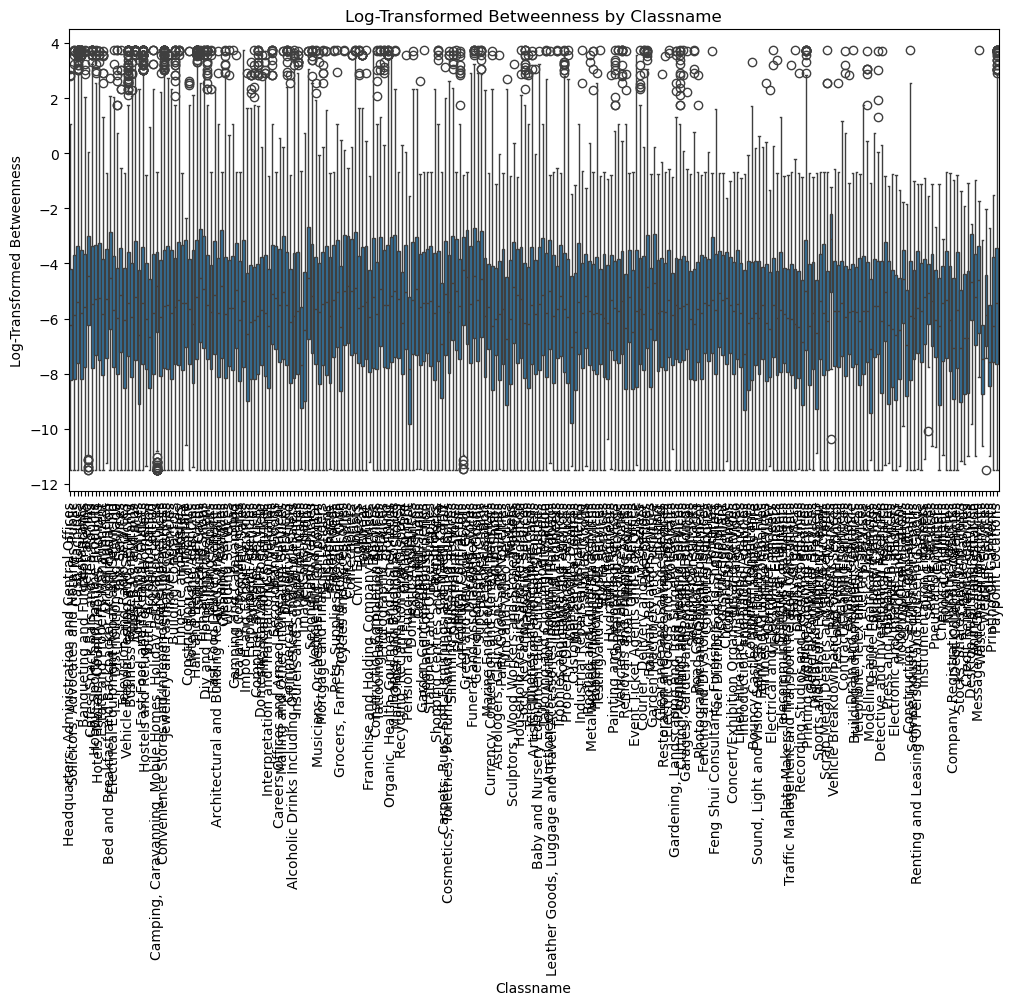

In [20]:
# load cluster data
cluster_df = pd.read_csv('Data/clusterdata.csv')

# convert 'geometry' & > gdf
cluster_df['geometry'] = cluster_df['geometry'].apply(wkt.loads)
cluster_data = gpd.GeoDataFrame(cluster_df, geometry='geometry')

# EPSG:27700
cluster_data.set_crs(epsg=27700, inplace=True)
retail_gdf.set_crs(epsg=27700, inplace=True)

# check CRS match
cluster_data = cluster_data.to_crs(retail_gdf.crs)

# include only points within clusters
# spatial join to find points within all clusters
all_clusters = cluster_data[['cluster_id', 'geometry']]
filtered_retail_gdf = gpd.sjoin(retail_gdf, all_clusters, how='inner', predicate='within')

# filter for retail group names
relevant_groupnames = ['Commercial Services', 'Accommodation, Eating and Drinking', 'Retail']
filtered_retail_gdf = filtered_retail_gdf[filtered_retail_gdf['groupname'].isin(relevant_groupnames)].copy()

# unsure why 
filtered_retail_gdf['shifted_betweenness'] = filtered_retail_gdf['betweenness'] + 1e-5

# Apply log transformation to the shifted values
filtered_retail_gdf['log_shifted_betweenness'] = np.log(filtered_retail_gdf['shifted_betweenness'])

# Ensure the 'log_shifted_betweenness' column is numeric and remove any rows with NaN or infinite values
filtered_retail_gdf = filtered_retail_gdf.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_shifted_betweenness'])

# Check if the filtered dataset is empty
if filtered_retail_gdf.empty:
    print("Filtered dataset is empty. Please check the data and filtering criteria.")
else:
    # Step 1: Calculate the median and mean log-transformed betweenness centrality for each 'classname'
    stats_log_betweenness = filtered_retail_gdf.groupby('classname')['log_shifted_betweenness'].agg(['median', 'mean']).reset_index()
    stats_log_betweenness.columns = ['classname', 'median_log_betweenness', 'mean_log_betweenness']

    # Check for any NaN values in the calculated statistics
    if stats_log_betweenness[['median_log_betweenness', 'mean_log_betweenness']].isnull().any().any():
        print("NaN values found in calculated statistics. Please check the data and calculations.")
    else:
        # Step 2: Encode the 'classname' values
        label_encoder = LabelEncoder()
        stats_log_betweenness['classname_encoded'] = label_encoder.fit_transform(stats_log_betweenness['classname'])

        # Step 3: Calculate the Spearman correlation for median and mean
        correlation_median, p_value_median = spearmanr(stats_log_betweenness['classname_encoded'], stats_log_betweenness['median_log_betweenness'])
        correlation_mean, p_value_mean = spearmanr(stats_log_betweenness['classname_encoded'], stats_log_betweenness['mean_log_betweenness'])

        # Display the results
        print(f"Spearman Correlation Coefficient (Median): {correlation_median}")
        print(f"P-value (Median): {p_value_median}")
        print(f"Spearman Correlation Coefficient (Mean): {correlation_mean}")
        print(f"P-value (Mean): {p_value_mean}")

        # Plot the relationship between class names and log-transformed median and mean betweenness
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='classname', y='log_shifted_betweenness', data=filtered_retail_gdf)
        plt.xticks(rotation=90)
        plt.title('Log-Transformed Betweenness by Classname')
        plt.xlabel('Classname')
        plt.ylabel('Log-Transformed Betweenness')
        plt.show()